# Data exploration demo

In this notebook we will show the validation dataset that we created for the work [*Unsupervised Change Detection of Extreme Events Using ML On-Board*](http://arxiv.org/abs/2111.02995). This work was conducted at the [FDL Europe 2021](https://fdleurope.org/fdl-europe-2021) research accelerator program. 

The validation dataset contains 19 identified events with natural disasters. For each of these events we obtained 4 Sentinel-2 images prior to the event and 1 image after the event. Additionally, we created a manually derived change mask with the identified changes in the last image. This dataset is hosted in this [public Google Drive folder](https://drive.google.com/drive/folders/1VEf49IDYFXGKcfvMsfh33VSiyx5MpHEn?usp=sharing).

In this notebook we show how to access and plot this validation data.


In [ ]:
!pip install rasterio
!pip install --quiet --upgrade gdown

     |████████████████████████████████| 19.3 MB 351 kB/s 


## Get the data

If you’re running this tutorial in **Google Colab** you need to *'add a shortcut to your Google Drive’* from our [public Google Drive folder](https://drive.google.com/drive/folders/1VEf49IDYFXGKcfvMsfh33VSiyx5MpHEn?usp=sharing) and mount that directory with the following code:

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

public_folder = '/content/drive/My Drive/FDL21_RaVAEn_datasets'
assert os.path.exists(public_folder), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/folders/1VEf49IDYFXGKcfvMsfh33VSiyx5MpHEn?usp=sharing"

Mounted at /content/drive


If you're running in a **jupyter notebook** you should download the data from the [public Google Drive folder](https://drive.google.com/drive/folders/1VEf49IDYFXGKcfvMsfh33VSiyx5MpHEn?usp=sharing) manually or, alternatively you can try the `gdown` package for programatically download data from the Google Drive.

In [ ]:
# Alternatively download these with gdown:
"""
!gdown https://drive.google.com/uc?id=1UCNnxaL9pQSkkZQx0aDEWQL0UBXPXkv0 -O fires.zip
!gdown https://drive.google.com/uc?id=1CbNGrpK66Hos_TtOEut510k7CSHvSwkl -O landslides.zip
!gdown https://drive.google.com/uc?id=1VP3SYgh3bj6uPa4r_bKP-5zFP3JdGin8 -O hurricanes.zip
!gdown https://drive.google.com/uc?id=1scjd4gIB_eiNS-CsOyb7Q8rYWnl9TM-L -O floods.zip
public_folder = "." # because we downloaded these locally
"""

## Unzip the data

The following two cells unzips the data and list the ground truth files with the manually identified changes.

In [ ]:
from glob import glob
files_to_extract = sorted(glob(os.path.join(public_folder,"*.zip")))
print("All:",files_to_extract)

In [ ]:
import zipfile
from tqdm import tqdm

dataset_folder = "./datasets"
os.makedirs(dataset_folder, exist_ok=True)

for zip_files in tqdm(files_to_extract):
  with zipfile.ZipFile(zip_files, "r") as zip_ref:
    zip_ref.extractall(dataset_folder)
    zip_ref.close()

100%|██████████| 1/1 [00:31<00:00, 31.79s/it]


In [ ]:
ground_truth_files = sorted(glob(os.path.join(dataset_folder,"*","*","changes","*.tif")))
ground_truth_files

['./fires/fire_camp/changes/2018-12-06.tif',
 './fires/fire_carr/changes/2018-08-11.tif',
 './fires/fire_czu/changes/2020-09-06.tif',
 './fires/fire_mallacoota/changes/2020-01-25.tif',
 './fires/fire_riveaux/changes/2019-02-24.tif',
 './floods/EMSR260_02VIADANA/changes/2017-12-13.tif',
 './floods/EMSR271_02FARKADONA/changes/2018-02-28.tif',
 './floods/EMSR324_04LESPIGNAN/changes/2018-10-20.tif',
 './floods/EMSR333_02PORTOPALO/changes/2018-11-04.tif',
 './hurricanes/hurricane_dorian_bahamas/changes/2019-09-05.tif',
 './hurricanes/hurricane_harvey_otey/changes/2017-08-30.tif',
 './hurricanes/hurricane_irma_barbuda/changes/2017-09-24.tif',
 './hurricanes/hurricane_maria_stcroix/changes/2017-10-02.tif',
 './hurricanes/hurricane_michael_sanblas2/changes/2018-10-14.tif',
 './landslides/landslide_bigsur/changes/2017-05-27.tif',
 './landslides/landslide_fagraskogarfjall/changes/2018-07-17.tif',
 './landslides/landslide_santalucia/changes/2018-01-21.tif',
 './landslides/landslide_sierra/changes

## Plot the Sentinel-2 images and the change mask

In the following cell we will loop over the ground truth files with the identified changes and plot the available time series of Sentinel-2 images for that event over that location prior (4 images) and post (1 image) of the natural disaster plus the manual change mask.

  0%|          | 0/2 [00:00<?, ?it/s]

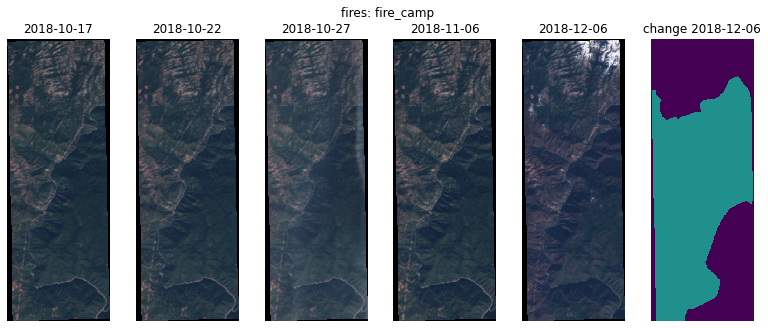

 50%|█████     | 1/2 [00:01<00:01,  1.09s/it]

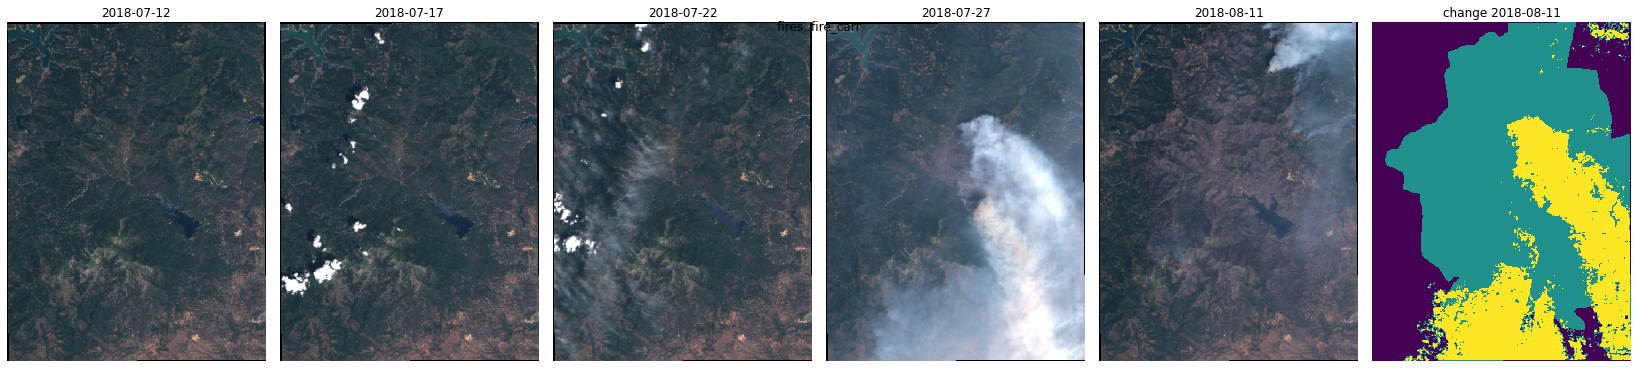

100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


In [ ]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt
import numpy as np
import rasterio


size_read = 600
for ft in tqdm(ground_truth_files): # ground_truth_files[0:2] for subset
  s2_files = sorted(glob(os.path.join(os.path.dirname(os.path.dirname(ft)),"S2","*.tif")))
  n_plots = len(s2_files) + 1

  with rasterio.open(ft) as src:
    width = src.width
    height = src.height

    # Compute shape to read to from pyramids and speed up plotting
    shape = src.shape
    if (size_read >= shape[0]) and (size_read >= shape[1]):
      out_shape = shape
    elif shape[0] > shape[1]:
      out_shape = (size_read, int(round(shape[1]/shape[0] * size_read)))
    else:
      out_shape = (int(round(shape[0] / shape[1] * size_read)), size_read)
    change = src.read(1, out_shape=out_shape)
  
  fig, ax = plt.subplots(1, n_plots, figsize=(n_plots*5*width/height,5), tight_layout=True)
  
  # Plot change
  rstplt.show(change, vmin=0,vmax=2, interpolation="nearest", ax=ax[-1])
  date = os.path.basename(ft)[:-4]
  name = ft.split("/")[-3]
  event_type = ft.split("/")[-4]
  ax[-1].set_title(f"change {date}")
  ax[-1].axis("off")

  # Plot S2 files
  for i, s2_file in enumerate(s2_files):
    with rasterio.open(s2_file) as src:
      img = src.read([4,3,2], out_shape=out_shape)

    img = np.clip(img/3000., 0, 1)
    rstplt.show(img, ax=ax[i])
    date = os.path.basename(s2_file)[:-4]
    ax[i].set_title(date)
    ax[i].axis("off")

  plt.suptitle(f"{event_type}: {name}")
  plt.show()
  # note: below left with the first two outputs as a demo

## Plot location of the data

In the following cell we will show the location of these events in the globle using the `folium` package.

In [ ]:
import folium
import rasterio.warp

color_code = {"volcanos":"pink",
              "fires":"red",
              "floods": "blue",
              "hurricanes": "lightgray",
              "oilspills": "purple",
              "landslides": "orange"}

map_bb = folium.Map(location=[0, 0],
                    zoom_start=3,tiles="Stamen Toner")

for ft in tqdm(ground_truth_files):
    with rasterio.open(ft) as src:
        bounds_utm = src.bounds
        bounds_lng_lat = rasterio.warp.transform_bounds(src.crs, {"init": "epsg:4326"}, *bounds_utm)
        lng_lat_center = src.lnglat()
        lat_lng_center = lng_lat_center[-1::-1]
        bounds_lng_lat = lng_lat_center[0] - 1, lng_lat_center[1] - 1, lng_lat_center[0] + 1, lng_lat_center[1] + 1
    
    date = os.path.basename(ft)[:-4]
    name = ft.split("/")[-3]
    event_type = ft.split("/")[-4]

    popup = name+"<br>Change date: "+ date
    ico = folium.Marker(location=list(lat_lng_center), 
                        icon=folium.Icon(color=color_code[event_type]),
                        popup=popup)
    
    map_bb.add_child(ico)
map_bb

100%|██████████| 19/19 [00:00<00:00, 69.43it/s]
